## Data from sediment 
In this notebook we will focus on 2 class classification based on enviromental supplementation.

In [1]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

np.random.seed(111)
tf.random.set_seed(111)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Sed/sed_bacteria_full_feature_table.csv')
df.head()



,pond,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sed_S10,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sed_S11,81.0,21.0,29.0,90.0,NaN,8.0,10.0,NaN,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sed_S11,3.0,13.0,18.0,3.0,NaN,3.0,18.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sed_S12,171.0,67.0,109.0,76.0,23.0,31.0,NaN,1.0,352.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
predictors = df.columns[1:]
len(predictors)

227

In [4]:
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"class_timepoint",  classes)

In [5]:
df.fillna(0, inplace=True)
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,87.880000,88.440000,238.540000,60.020000,13.140000,14.420000,17.660000,7.420000,103.480000,...,0.440000,0.720000,0.460000,0.30000,0.900000,0.260000,0.240000,0.220000,0.220000,0.200000
std,0.505076,72.437909,65.694767,359.278484,40.221068,21.783733,21.364753,24.860927,11.510581,127.867636,...,2.214608,4.549232,3.252691,2.12132,4.704535,1.838478,1.697056,1.555635,1.555635,1.414214
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,34.500000,24.000000,33.250000,0.000000,0.000000,0.000000,0.000000,3.250000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,82.000000,73.500000,88.500000,56.500000,4.000000,2.000000,6.000000,1.500000,51.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,126.250000,121.000000,297.000000,80.000000,19.500000,22.000000,28.000000,10.000000,196.750000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,368.000000,256.000000,1898.000000,170.000000,103.000000,86.000000,113.000000,52.000000,463.000000,...,13.000000,32.000000,23.000000,15.00000,30.000000,13.000000,12.000000,11.000000,11.000000,10.000000


In [6]:
# for normalisation we will use starndard min-max normalisation
df[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)


In [7]:
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,0.238804,0.345469,0.125680,0.353059,0.127573,0.167674,0.156283,0.142692,0.223499,...,0.033846,0.022500,0.020000,0.020000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000
std,0.505076,0.196842,0.256620,0.189293,0.236595,0.211493,0.248427,0.220008,0.221357,0.276172,...,0.170354,0.142163,0.141421,0.141421,0.156818,0.141421,0.141421,0.141421,0.141421,0.141421
min,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.086957,0.134766,0.012645,0.195588,0.000000,0.000000,0.000000,0.000000,0.007019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.222826,0.287109,0.046628,0.332353,0.038835,0.023256,0.053097,0.028846,0.110151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.343071,0.472656,0.156481,0.470588,0.189320,0.255814,0.247788,0.192308,0.424946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In this approach we will use 3 class classification based only on water supplementation 
Those classes will be: No supplementation, Em farma, EM

| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [8]:
# function for decoding pond number
def pond_decoder(x,codes):
    
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

In [9]:
# function for reseting model weights
def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))


In [10]:
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32], 2 : [9,13,17,20,27,11,15,22,25,31]}

df['pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))

In [11]:
pondXtime = df['pond'].astype(str) + "_" + df['class_timepoint'].astype(str)
df.insert(1,"pondXtime", pondXtime)

C:\Users\marek\AppData\Local\Temp\ipykernel_33620\1706034138.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1,"pondXtime", pondXtime)


In [12]:
df.head()
df['pondXtime'].value_counts()

pondXtime
1_0    10
1_1    10
2_0    10
2_1    10
0_0     5
0_1     5
Name: count, dtype: int64

As the splitting dataset into train/val and test didnt workout due to probably small number of samples we will stick to only train/val datasets

In [13]:
train_val_df = df.copy()

In [14]:
#train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
#print(train_val_df.shape, test_df.shape)

For crossvalidation purposes we will create 5 subsets of size 10 each, 4 of them will be used as train dataset and one as validating dataset.  This then will be repeated 4 times and validation result will be mean of results.

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


### Modeling differences between Classes for both timepoints at the same time

In [16]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))


model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(3, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,803 (151.57 KB)

 Trainable params: 38,803 (151.57 KB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=1000,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

Here in one loop we will iterate over all datasets train and validate for each of them and gather results. Using corssvalidation. We will also introduce for debugging purposes, confidence score metric. It is calculated for each predicted label from validation/test dataset. As we probably know output from softmax layer is vector of probabilitis of belonging to each clas 

In [18]:
def crossvalidate(train_val_df, model, predictors, target, kf):
    '''function for crossvalidation of the model
    train_val_df - dataframe with train and validate data
    model - model to be trained
    predictors - list of predictors
    target - target variable
    kf - KFold object
    es_callback - EarlyStopping callback
    '''

    
    i=1

    acc_scores = []
    loss_scores = []

    acc_histories = []
    loss_histories = []
    val_acc_histories = []
    val_loss_histories = []

    global_confidence_scores = []


    for train_index, validate_index in kf.split(train_val_df):
        # reset weights
        reset_weights(model)
        
        train_df = train_val_df.iloc[train_index]
        validate_df = train_val_df.iloc[validate_index]

        # create train and validate datasets 
        X_train = train_df[predictors].values
        y_train = train_df[target].values
        y_train = keras.utils.to_categorical(y_train)

        X_validate = validate_df[predictors].values
        y_validate = validate_df[target].values
        y_validate = keras.utils.to_categorical(y_validate)

        # fit the model
        print(f"training for {i} subset")
        history = model.fit(X_train, y_train, epochs=300, batch_size=5, validation_data=(X_validate, y_validate), verbose=0)
        # evaluate the model

        ev_results = model.evaluate(X_validate, y_validate)



        #save evaluation results 
        acc_scores.append(ev_results[1])
        loss_scores.append(ev_results[0])

        acc_histories.append(history.history['accuracy'])
        loss_histories.append(history.history['loss'])
        val_acc_histories.append(history.history['val_accuracy'])
        val_loss_histories.append(history.history['val_loss'])

        # prediction of the results 
        y_pred = model.predict(X_validate)
        y_pred_class = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_validate, axis=1)
        print(f"predicted classes:       {y_pred_class}")
        print(f"true validation classes: {y_true}")

        # confidence scores 

        confidence_scores = []
        for row in y_pred:
            highest = np.max(row)
            mean = np.mean(np.delete(row, np.argmax(row)))
            confidence_score = round(((highest / mean)-1),4)
            confidence_scores.append(confidence_score)
            global_confidence_scores.append(confidence_score)
        
        mean_confidence = np.mean(confidence_scores)
        sd_confidence = np.std(confidence_scores)

        print(f"mean confidence score: {round(mean_confidence,4)}, sd confidence score: {round(sd_confidence,4)}")
        print("=====================================================")

        



        i+=1

    # calculate mean scores

    mean_acc_score = np.mean(acc_scores)
    sd_acc_score = np.std(acc_scores)
    mean_loss_score = np.mean(loss_scores)
    sd_loss_score = np.std(loss_scores)


    # part to plot mean values from history
    
    # mean and sd values for learning curves 
    mean_acc_histories = np.nanmean(acc_histories, axis=0)
    sd_acc_histories = np.nanstd(acc_histories, axis=0)
    mean_val_acc_histories = np.nanmean(val_acc_histories, axis=0)
    sd_val_acc_histories = np.nanstd(val_acc_histories, axis=0)
    mean_loss_histories = np.nanmean(loss_histories, axis=0)
    sd_loss_histories = np.nanstd(loss_histories, axis=0)
    mean_val_loss_histories = np.nanmean(val_loss_histories, axis=0)
    sd_val_loss_histories = np.nanstd(val_loss_histories, axis=0)
    

    print(f"validation set mean accuracy: {round(mean_acc_score,4)}, sd{round(sd_acc_score,4)}, mean loss: {round(mean_loss_score,4)}, sd: {round(sd_loss_score,4)}")
    print(f"global mean confidence score: {round(np.mean(global_confidence_scores),4)}, sd confidence score: {round(np.std(global_confidence_scores),4)}")
    # plotting mean curves 

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(mean_acc_histories, label='train', color='blue')
    plt.fill_between(range(len(mean_acc_histories)), mean_acc_histories - sd_acc_histories, mean_acc_histories + sd_acc_histories, color='blue', alpha=0.2)
    plt.plot(mean_val_acc_histories, label='validate', color='orange')
    plt.fill_between(range(len(mean_val_acc_histories)), mean_val_acc_histories - sd_val_acc_histories, mean_val_acc_histories + sd_val_acc_histories, color='orange', alpha=0.2)
    plt.legend()
    plt.title("Mean Accuracy")

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(mean_loss_histories, label='train', color='blue')
    plt.fill_between(range(len(mean_loss_histories)), mean_loss_histories - sd_loss_histories, mean_loss_histories + sd_loss_histories, color='blue', alpha=0.2)
    plt.plot(mean_val_loss_histories, label='validate', color='orange')
    plt.fill_between(range(len(mean_val_loss_histories)), mean_val_loss_histories - sd_val_loss_histories, mean_val_loss_histories + sd_val_loss_histories, color='orange', alpha=0.2)
    plt.legend()
    plt.title("Mean Loss")

    plt.show()


    # calculating min and max values for loss plots range 
    flat_loss_histories = np.concatenate(loss_histories)
    flat_val_loss_histories = np.concatenate(val_loss_histories)
    min_loss = min((min(flat_loss_histories), min(flat_val_loss_histories)))
    max_loss = max((max(flat_loss_histories), max(flat_val_loss_histories)))



    # Plotting results for each fold 
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))


    # Accuracy
    for i, acc in enumerate(acc_histories):
        axs[0, 0].plot(acc, label=f'Fold {i+1}')
    axs[0, 0].set_title('Training Accuracy')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    axs[0, 0].legend()

    # Validation Accuracy
    for i, val_acc in enumerate(val_acc_histories):
        axs[0, 1].plot(val_acc, label=f'Fold {i+1}')
    axs[0, 1].set_title('Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    axs[0, 1].legend()

    # Loss
    for i, loss in enumerate(loss_histories):
        axs[1, 0].plot(loss, label=f'Fold {i+1}')
    axs[1, 0].set_title('Training Loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].set_ylim(min_loss,max_loss)  # Set y-axis scale based on the maximum loss value
    axs[1, 0].legend()

    # Validation Loss
    for i, val_loss in enumerate(val_loss_histories):
        axs[1, 1].plot(val_loss, label=f'Fold {i+1}')
    axs[1, 1].set_title('Validation Loss')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].set_ylim(min_loss,max_loss)  # Set y-axis scale based on the maximum validation loss value
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()




In [21]:
def crossvalidate(train_val_df, model, predictors, target, kf):
    '''function for crossvalidation of the model
    train_val_df - dataframe with train and validate data
    model - model to be trained
    predictors - list of predictors
    target - target variable
    kf - KFold object
    es_callback - EarlyStopping callback
    '''

    
    i=1

    acc_scores = []
    loss_scores = []

    acc_histories = []
    loss_histories = []
    val_acc_histories = []
    val_loss_histories = []

    global_confidence_scores = []


    for train_index, validate_index in kf.split(train_val_df):
        # reset weights
        reset_weights(model)
        
        train_df = train_val_df.iloc[train_index]
        validate_df = train_val_df.iloc[validate_index]

        # create train and validate datasets 
        X_train = train_df[predictors].values
        y_train = train_df[target].values
        y_train = keras.utils.to_categorical(y_train)

        X_validate = validate_df[predictors].values
        y_validate = validate_df[target].values
        y_validate = keras.utils.to_categorical(y_validate)

        # fit the model
        print(f"training for {i} subset")
        history = model.fit(X_train, y_train, epochs=300, batch_size=5, validation_data=(X_validate, y_validate), verbose=0)
        # evaluate the model

        ev_results = model.evaluate(X_validate, y_validate)



        #save evaluation results 
        acc_scores.append(ev_results[1])
        loss_scores.append(ev_results[0])

        acc_histories.append(history.history['accuracy'])
        loss_histories.append(history.history['loss'])
        val_acc_histories.append(history.history['val_accuracy'])
        val_loss_histories.append(history.history['val_loss'])

        # prediction of the results 
        y_pred = model.predict(X_validate)
        y_pred_class = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_validate, axis=1)
        print(f"predicted classes:       {y_pred_class}")
        print(f"true validation classes: {y_true}")

        # confidence scores 

        confidence_scores = []
        for row in y_pred:
            highest = np.max(row)
            mean = np.mean(np.delete(row, np.argmax(row)))
            confidence_score = round(((highest / mean)-1),4)
            confidence_scores.append(confidence_score)
            global_confidence_scores.append(confidence_score)
        
        mean_confidence = np.mean(confidence_scores)
        sd_confidence = np.std(confidence_scores)

        print(f"mean confidence score: {round(mean_confidence,4)}, sd confidence score: {round(sd_confidence,4)}")
        print("=====================================================")

        



        i+=1

    # calculate mean scores

    mean_acc_score = np.mean(acc_scores)
    sd_acc_score = np.std(acc_scores)
    mean_loss_score = np.mean(loss_scores)
    sd_loss_score = np.std(loss_scores)


    # part to plot mean values from history
    
    # mean and sd values for learning curves 
    mean_acc_histories = np.nanmean(acc_histories, axis=0)
    sd_acc_histories = np.nanstd(acc_histories, axis=0)
    mean_val_acc_histories = np.nanmean(val_acc_histories, axis=0)
    sd_val_acc_histories = np.nanstd(val_acc_histories, axis=0)
    mean_loss_histories = np.nanmean(loss_histories, axis=0)
    sd_loss_histories = np.nanstd(loss_histories, axis=0)
    mean_val_loss_histories = np.nanmean(val_loss_histories, axis=0)
    sd_val_loss_histories = np.nanstd(val_loss_histories, axis=0)
    

    print(f"validation set mean accuracy: {round(mean_acc_score,4)}, sd{round(sd_acc_score,4)}, mean loss: {round(mean_loss_score,4)}, sd: {round(sd_loss_score,4)}")
    print(f"global mean confidence score: {round(np.mean(global_confidence_scores),4)}, sd confidence score: {round(np.std(global_confidence_scores),4)}")
    # plotting mean curves 

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(mean_acc_histories, label='train', color='blue')
    plt.fill_between(range(len(mean_acc_histories)), mean_acc_histories - sd_acc_histories, mean_acc_histories + sd_acc_histories, color='blue', alpha=0.2)
    plt.plot(mean_val_acc_histories, label='validate', color='orange')
    plt.fill_between(range(len(mean_val_acc_histories)), mean_val_acc_histories - sd_val_acc_histories, mean_val_acc_histories + sd_val_acc_histories, color='orange', alpha=0.2)
    plt.legend()
    plt.title("Mean Accuracy")

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(mean_loss_histories, label='train', color='blue')
    plt.fill_between(range(len(mean_loss_histories)), mean_loss_histories - sd_loss_histories, mean_loss_histories + sd_loss_histories, color='blue', alpha=0.2)
    plt.plot(mean_val_loss_histories, label='validate', color='orange')
    plt.fill_between(range(len(mean_val_loss_histories)), mean_val_loss_histories - sd_val_loss_histories, mean_val_loss_histories + sd_val_loss_histories, color='orange', alpha=0.2)
    plt.legend()
    plt.title("Mean Loss")

    plt.show()


    # calculating min and max values for loss plots range 
    flat_loss_histories = np.concatenate(loss_histories)
    flat_val_loss_histories = np.concatenate(val_loss_histories)
    min_loss = min((min(flat_loss_histories), min(flat_val_loss_histories)))
    max_loss = max((max(flat_loss_histories), max(flat_val_loss_histories)))



    # Plotting results for each fold 
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))


    # Accuracy
    for i, acc in enumerate(acc_histories):
        axs[0, 0].plot(acc, label=f'Fold {i+1}')
    axs[0, 0].set_title('Training Accuracy')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    axs[0, 0].legend()

    # Validation Accuracy
    for i, val_acc in enumerate(val_acc_histories):
        axs[0, 1].plot(val_acc, label=f'Fold {i+1}')
    axs[0, 1].set_title('Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    axs[0, 1].legend()

    # Loss
    for i, loss in enumerate(loss_histories):
        axs[1, 0].plot(loss, label=f'Fold {i+1}')
    axs[1, 0].set_title('Training Loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].set_ylim(min_loss,max_loss)  # Set y-axis scale based on the maximum loss value
    axs[1, 0].legend()

    # Validation Loss
    for i, val_loss in enumerate(val_loss_histories):
        axs[1, 1].plot(val_loss, label=f'Fold {i+1}')
    axs[1, 1].set_title('Validation Loss')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].set_ylim(min_loss,max_loss)  # Set y-axis scale based on the maximum validation loss value
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()




training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3000 - loss: 2.8160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
predicted classes:       [1 2 1 1 1 2 2 1 1 0]
true validation classes: [1 0 0 0 2 2 1 2 2 0]
mean confidence score: 200.7526, sd confidence score: 537.0039
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3000 - loss: 2.1934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [0 1 2 1 1 2 1 1 2 1]
true validation classes: [2 1 0 2 2 1 1 0 2 2]
mean confidence score: 9.1213, sd confidence score: 5.2626
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 1.6194
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [2 2 0 1 2 1 2 2 2 2]
true validation classes: [1 2 0 1 2 1 1 1 1 1]
mean confidence score: 11.1064, sd confidence score: 10.3408
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2000 - loss: 3.2170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predic

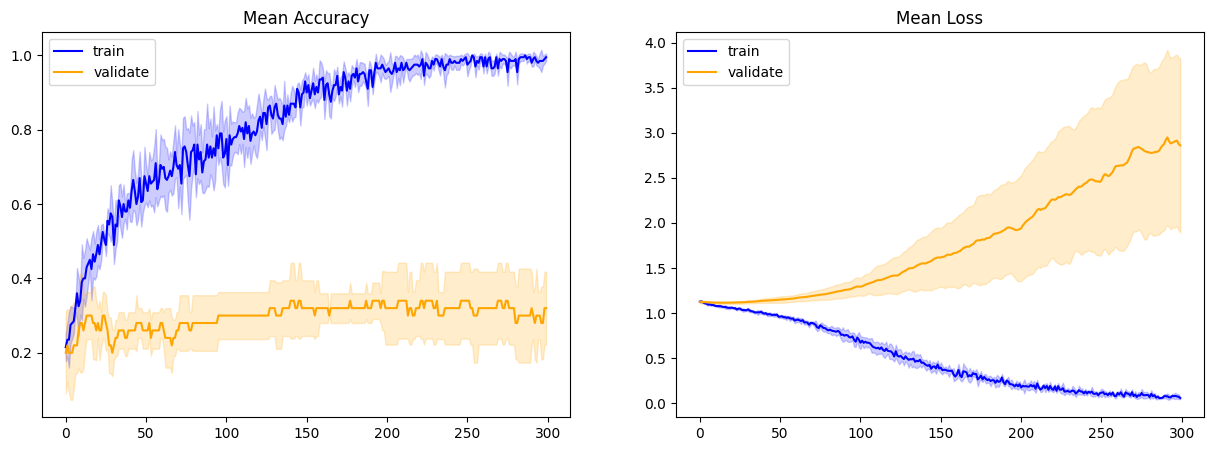

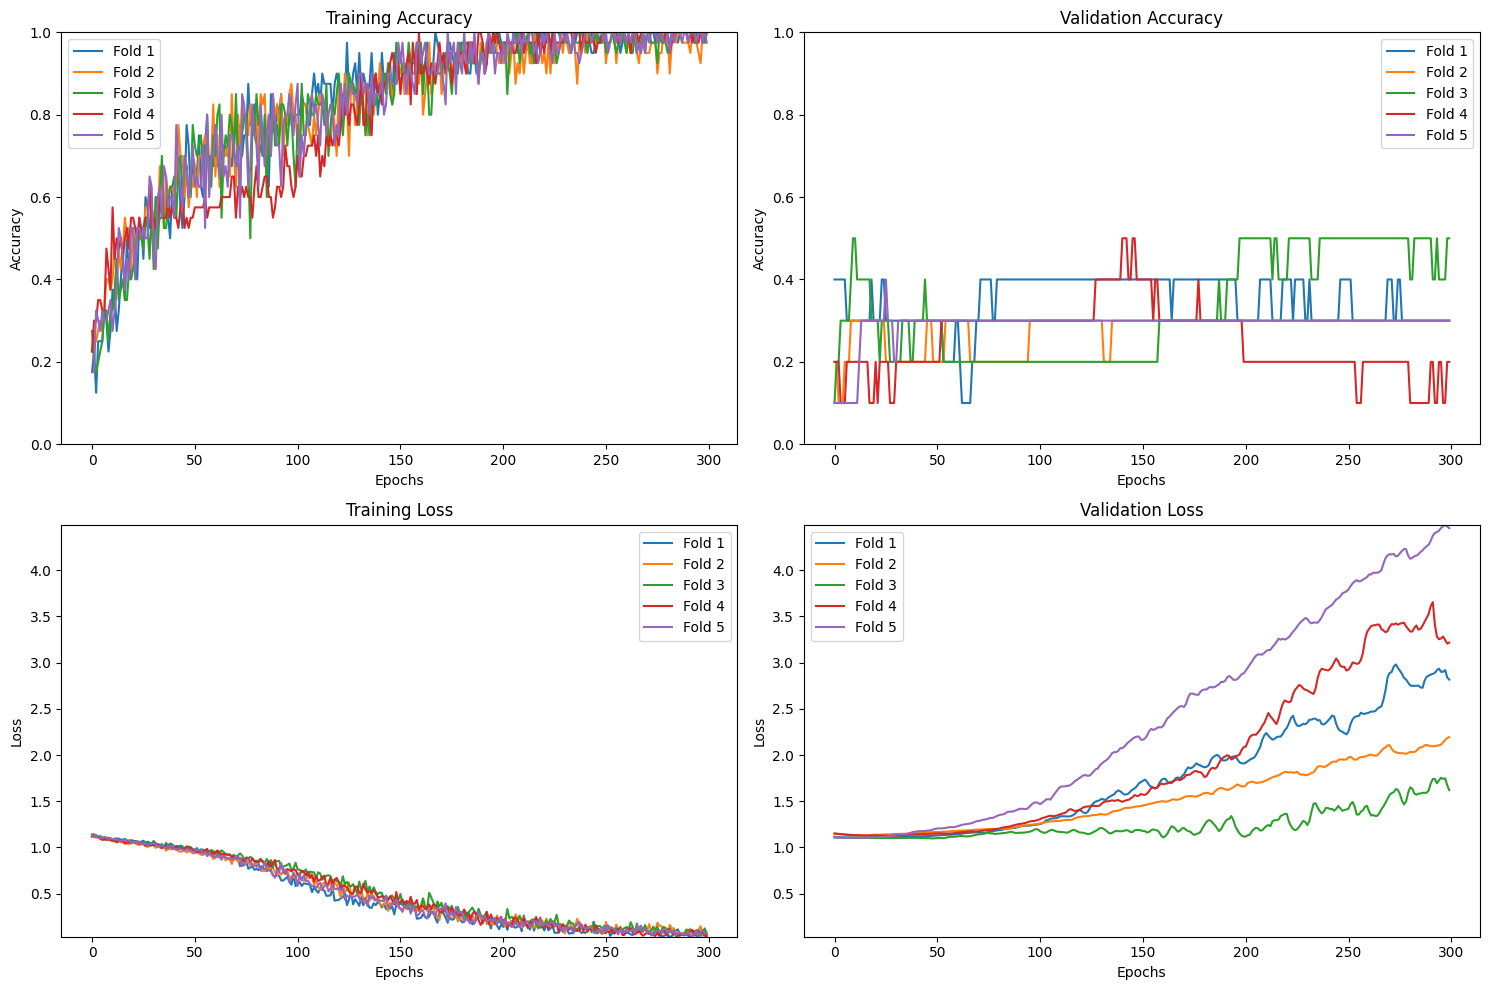

In [19]:
crossvalidate(train_val_df, model2, predictors, 'pond', kf)

After crossvalidation we can note that the results are bad, we can see overfitting problem happening with since very beggining of training.
But after removing test dataset and thus adding 10 more samples to learning process we can see that the model is no longer predicting everything as class 1. The lines for training datasets have small standard deviation and The confidence score is high. That means that the model is learing. The problem with results can be caused by bad model or lack of differences cused by classifying 2 timepoints at the same time. We can fix that by creating 6 classes or learning and classyfing on only one timepoint. 

### Modeling class differences in second timepoint

In this section we will classify based on differences in between enviromental supplementation in second timepoint only. biologicaly there should be more differences on this timepoint as enviroment had timne to react to supplementation.

In [20]:
df_second_tp = train_val_df[train_val_df["class_timepoint"]==1]
print(df_second_tp.shape)
df_second_tp.head()

(25, 230)


,pond,pondXtime,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
1,1,1_1,1,0.048913,0.585938,0.005269,0.758824,0.000000,0.000000,0.265487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,2_1,1,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,1_1,1,0.127717,0.343750,0.012645,0.247059,0.000000,0.023256,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2,2_1,1,0.380435,0.441406,0.197050,0.394118,0.029126,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0_1,1,0.491848,0.859375,0.131191,0.276471,0.223301,0.488372,0.353982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(3, activation ='softmax'))

model3.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,531 (150.51 KB)

 Trainable params: 38,531 (150.51 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2000 - loss: 2.7123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [1 1 1 1 1]
true validation classes: [2 0 1 0 2]
mean confidence score: 15.9694, sd confidence score: 9.7054
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 1.1999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 0 1 1 2]
true validation classes: [2 1 1 2 1]
mean confidence score: 1.3197, sd confidence score: 0.8758
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4000 - loss: 1.1871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [1 0 1 1 1]
true validation classes: [1 2 2 1 0]
mean confidence score: 1.3278, sd confidence score: 1.1134
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4000 - loss: 1.7945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted classes:       [2 2 2 1 1]
true validation classes: [1 2 0 1 2

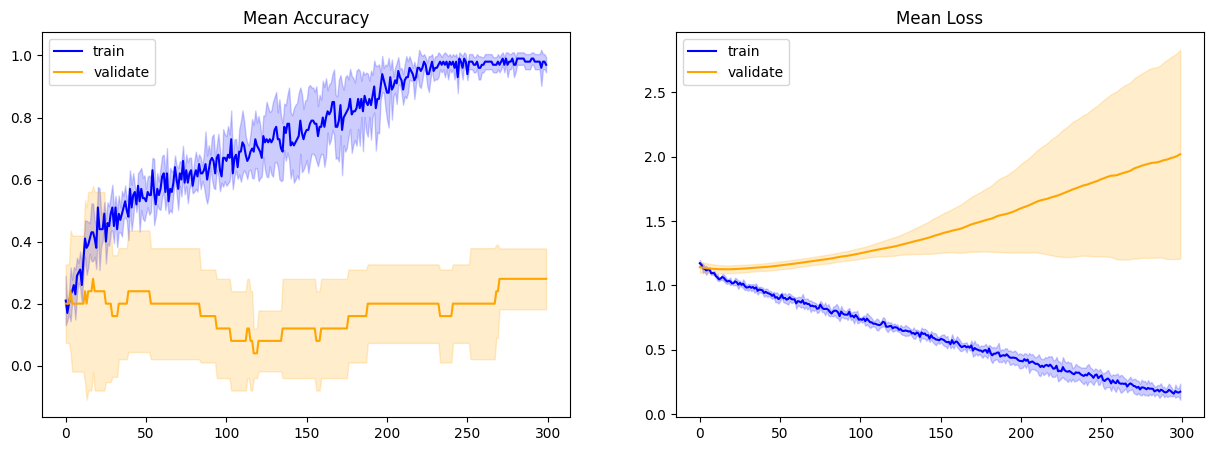

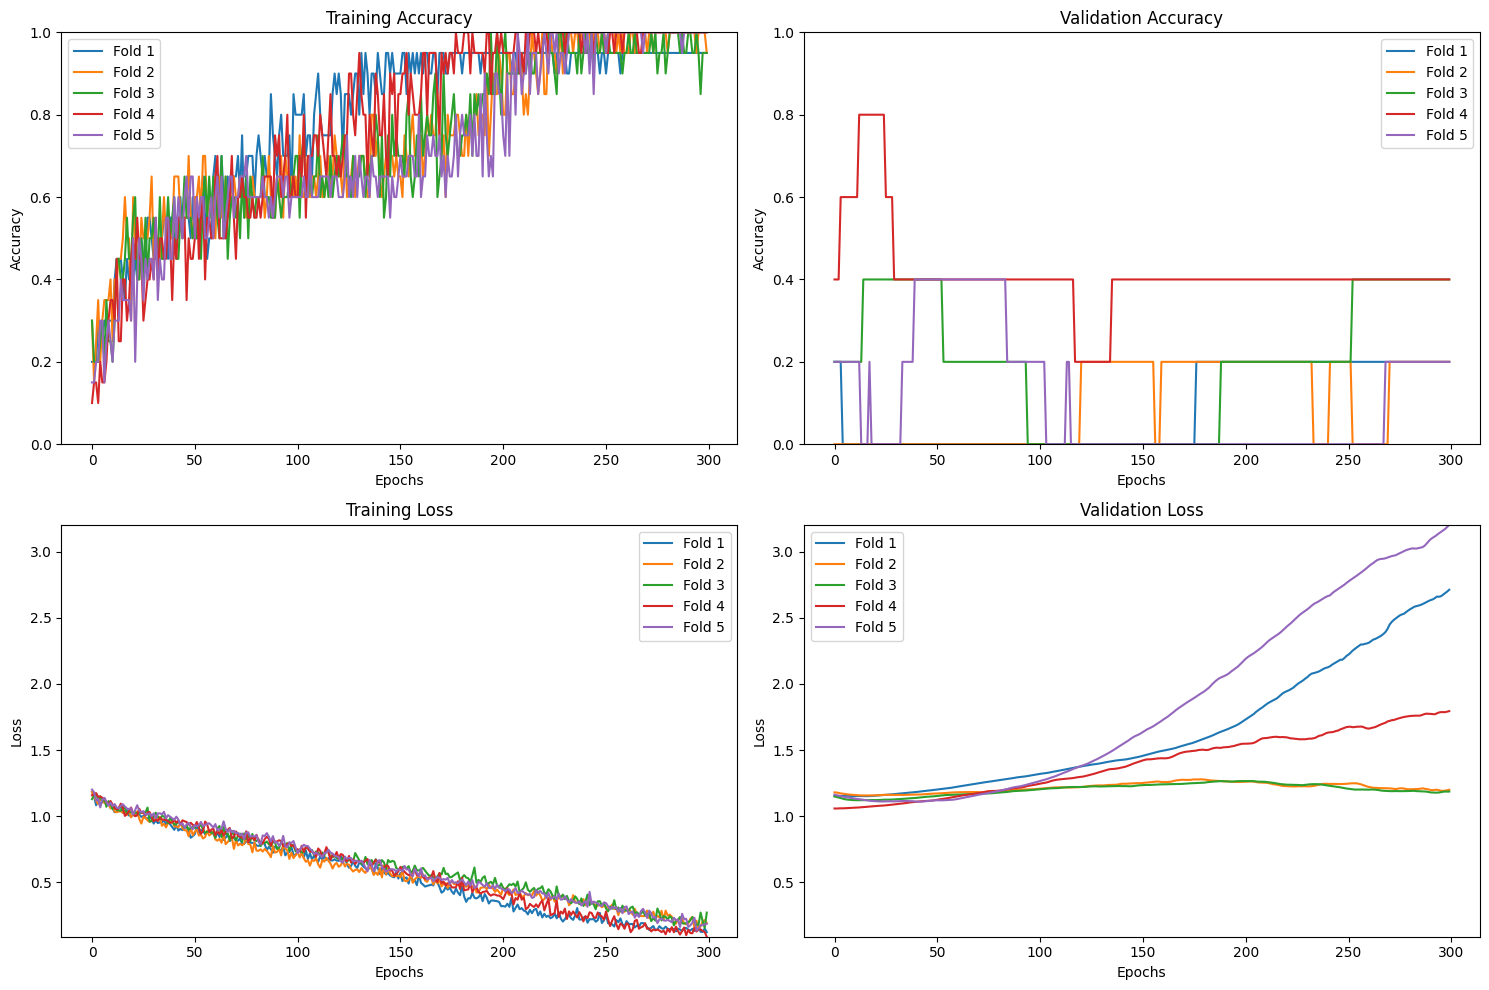

In [74]:
crossvalidate(df_second_tp, model3, predictors, 'pond', kf)

The results for second timepoint are slightly worse than for both timepoints, this is contradictionary to our thoughts that there should be differences between classes in second timepoint. Cause of that can be that we reduced number of sample down to 25 wchich is very low for DL applications. We will now check modeling for first timepoint.

### Modeling class differences in first timepoint

In this section we will atempt to classify based on first timepoint data, untill this time bad classification results on both timepoints suggest that there are differences between timepoints, we had good classsification on second timepoint so we can note that there are differences between classes. Now we haave to check if there are any differences on first timepoint.

In [24]:
df_first_tp = train_val_df[train_val_df["class_timepoint"]==0]
print(df_first_tp.shape)
df_first_tp.head()

(25, 230)


,pond,pondXtime,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,1,1_0,0,0.301630,0.500000,0.064278,0.594118,0.815534,0.511628,0.371681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2_0,0,0.220109,0.082031,0.015279,0.529412,0.000000,0.093023,0.088496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1_0,0,0.464674,0.261719,0.057429,0.447059,0.223301,0.360465,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2,2_0,0,0.173913,0.722656,0.000000,0.435294,0.106796,0.220930,0.530973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0_0,0,0.095109,0.269531,0.007903,0.017647,0.000000,0.000000,0.362832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(3, activation ='softmax'))

model4.summary()


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)



C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,907 (296.51 KB)

 Trainable params: 75,907 (296.51 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4000 - loss: 1.7619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [1 1 1 2 2]
true validation classes: [2 0 1 0 2]
mean confidence score: 47.395, sd confidence score: 60.4116
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 2.4527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 2 2 0 0]
true validation classes: [2 1 1 2 1]
mean confidence score: 23.5739, sd confidence score: 42.317
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6000 - loss: 0.6015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicted classes:       [1 1 1 1 0]
true validation classes: [1 2 2 1 0]
mean confidence score: 18.4304, sd confidence score: 25.8954
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 1.9109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [2 1 1 2 1]
true validation classes

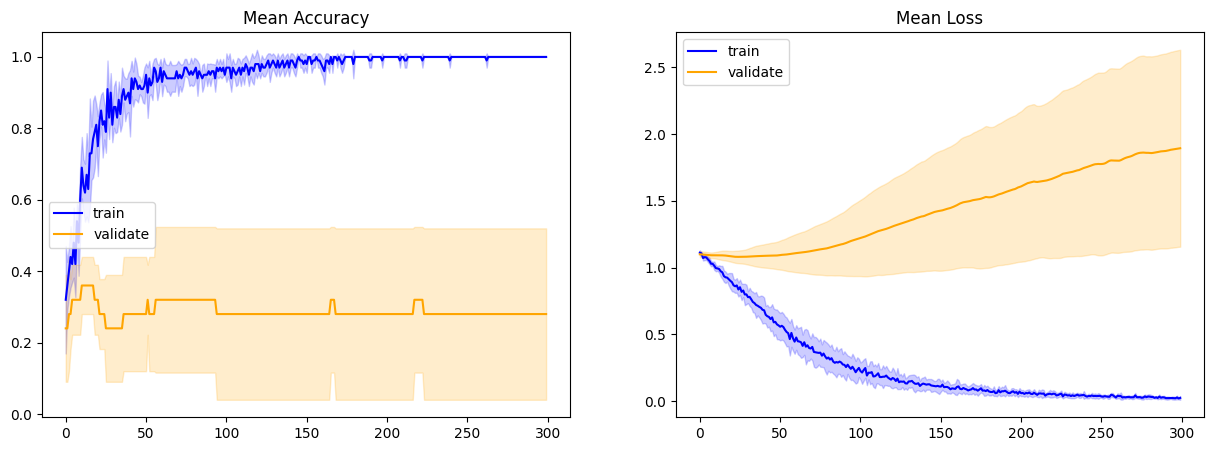

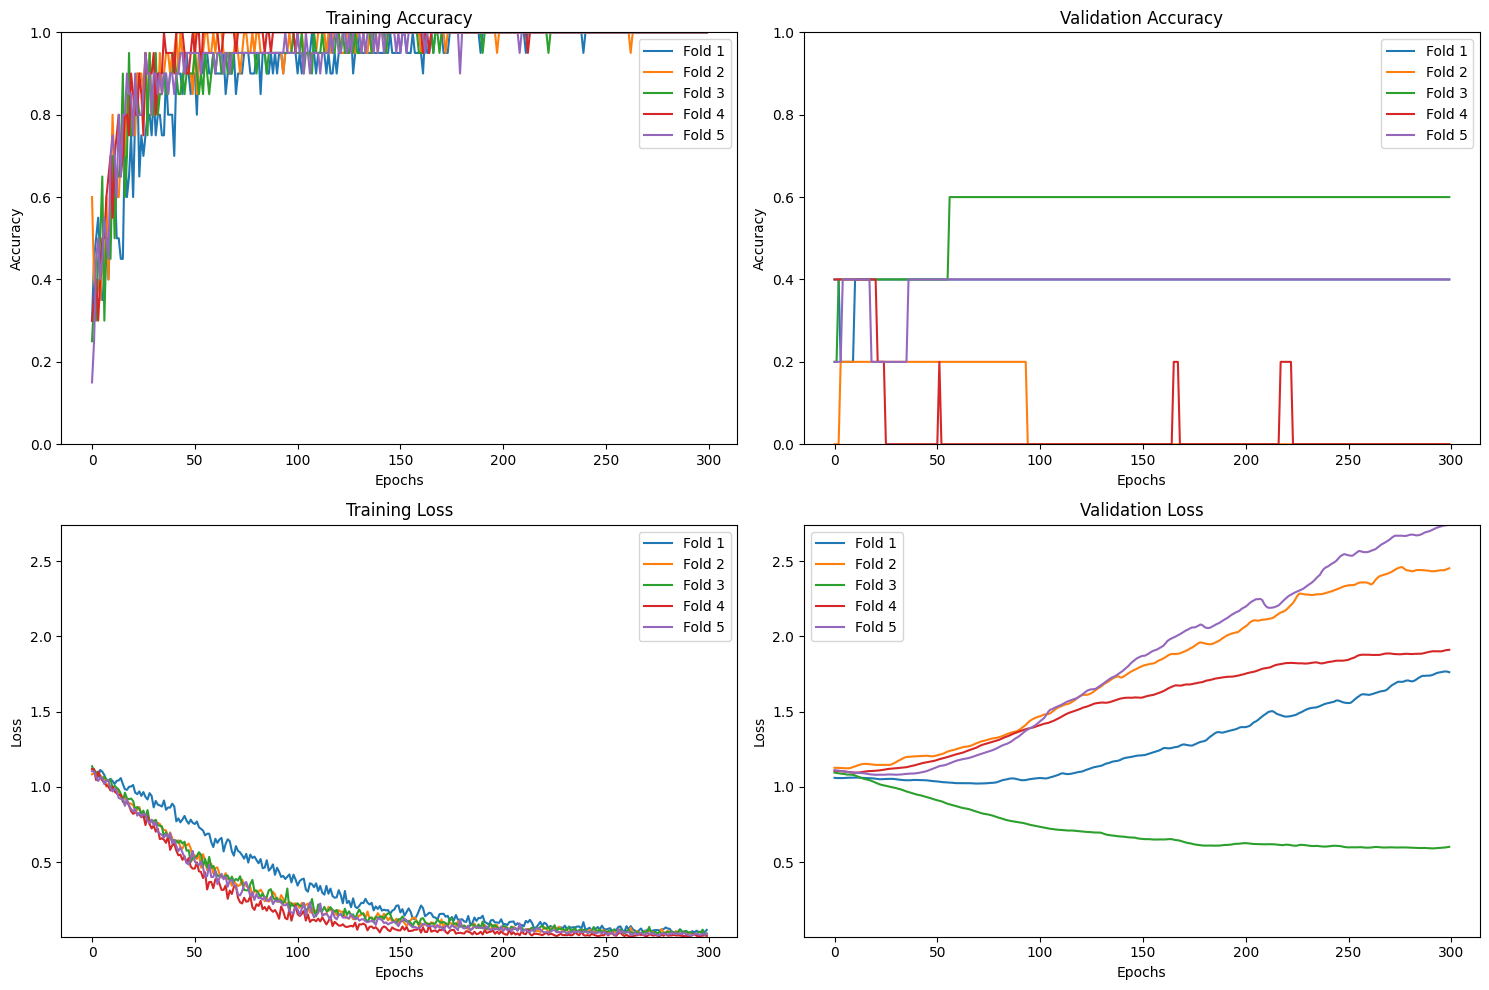

In [26]:
crossvalidate(df_first_tp, model4, predictors, 'pond', kf)

The results for 1'st timepoint are also not great to say the least. We will go on and check last option which is 6 class (time*class) to get all 50 samples for analysys.

In [16]:
model5 = keras.Sequential()



model5.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model5.add(keras.layers.Dropout(rate=0.25))
model5.add(keras.layers.Dense(64, activation ='relu'))
model5.add(keras.layers.Dropout(rate=0.25))
model5.add(keras.layers.Dense(16, activation ='relu'))

model5.add(keras.layers.Dense(6, activation ='softmax'))


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model5.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
train_val_df['pondXtime_encoded'] = LabelEncoder().fit_transform(train_val_df['pondXtime'])
train_val_df['pondXtime_encoded'] = train_val_df['pondXtime_encoded'].astype(int)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.1000 - loss: 3.4900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
predicted classes:       [3 2 5 3 3 3 3 2 3 5]
true validation classes: [2 0 1 1 4 5 3 4 5 0]
mean confidence score: 96.7181, sd confidence score: 230.3602
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2000 - loss: 3.9140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predicted classes:       [1 2 4 2 2 3 3 3 3 3]
true validation classes: [5 2 1 5 5 3 2 0 5 4]
mean confidence score: 9.8549, sd confidence score: 9.9315
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: 4.2525
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [2 2 4 1 4 3 5 3 2 5]
true validation classes: [3 4 0 3 5 2 3 2 3 3]
mean confidence score: 70.499, sd confidence score: 195.5994
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 3.9592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

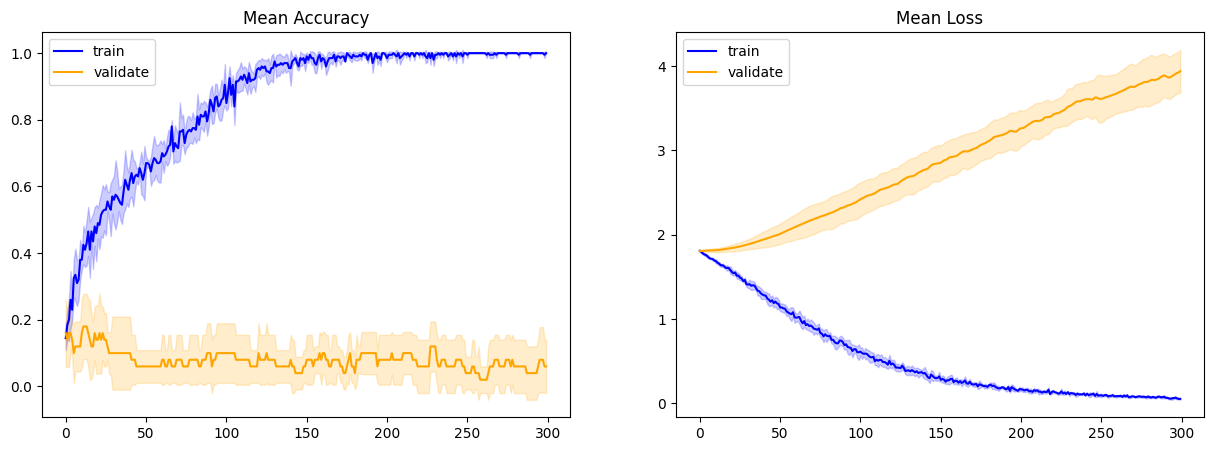

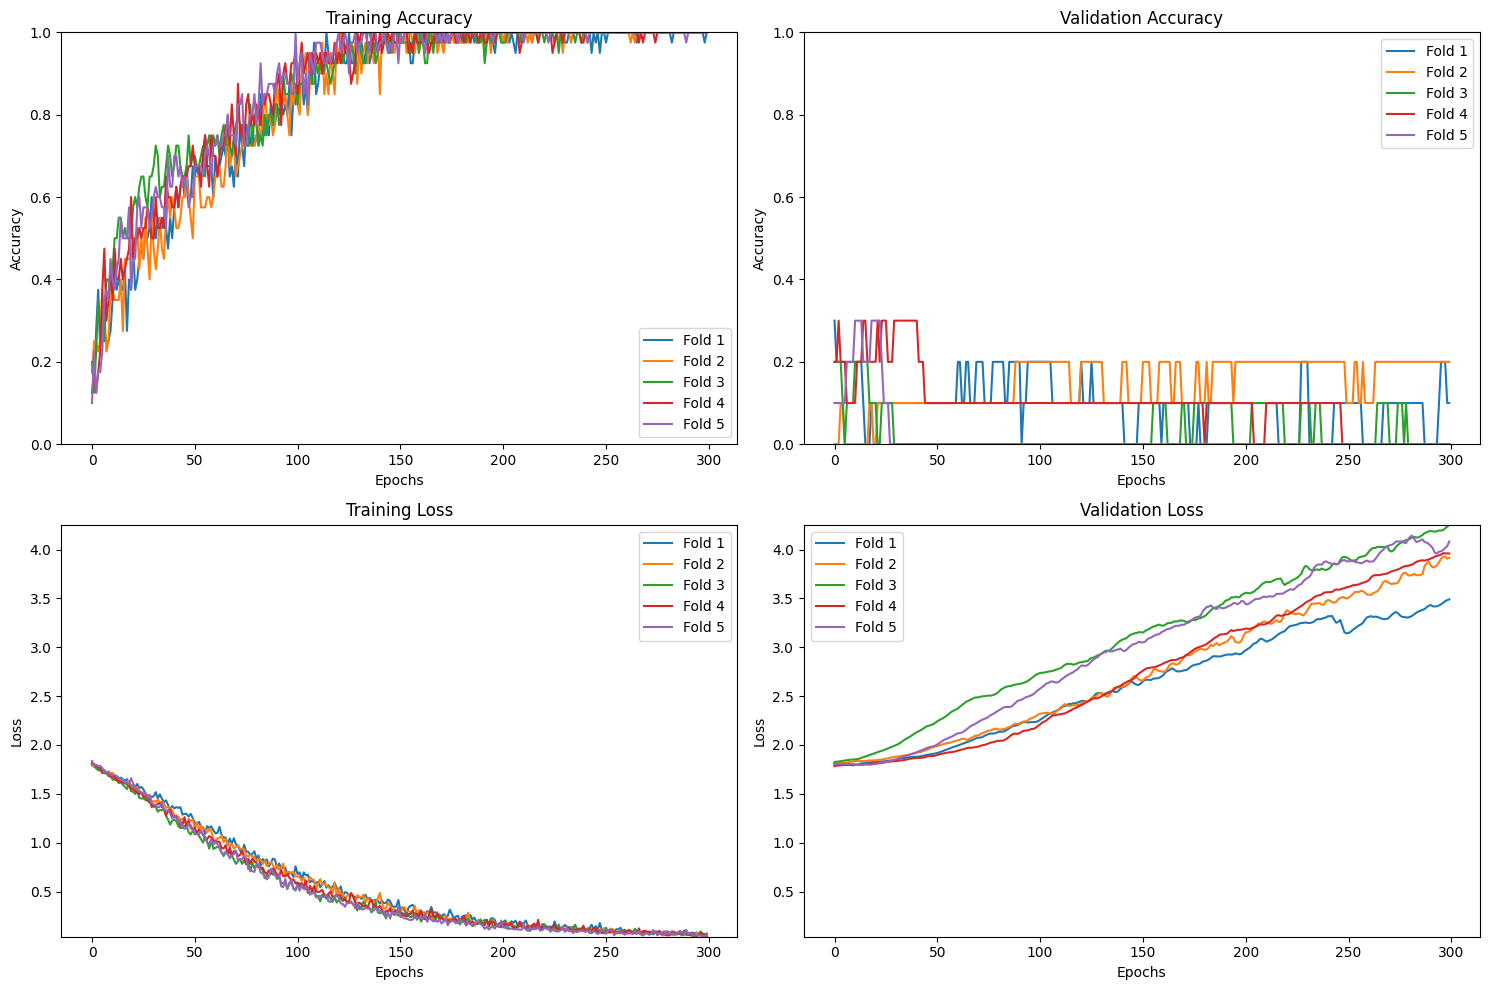

In [22]:
crossvalidate(train_val_df, model5, predictors, 'pondXtime_encoded', kf)

Classification for 6 classes didn't help either, as we didnt really improve class to samples ratio.

 In conclusion for all the modeling above we can say that 
1. The results were quite similar
2. mean validation accuracy didnt reach above 0.3 threshold wchich for 3 classes is worse than random choices. It is hard to say whenever the cause for that is too little samples or not enough differences but as we didnt have much better results for 5 classes i think 3 classes are better approach. 
3. The confidecnce score for all the models were quite high and loss curves for training were quite low, that indicates that model was learning and was "sure of it's decisions" This means that probable cause for low validation accuracy is low number of samples and overfitting caused by that. If there were no differences between classes confidence score should be lower. 

We will now check that by doing class exploration by performing one vs many classification for each class of  and seeing the results. This will be done in next notebook.